In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime as dt
import time
import numpy as np
import json
import os
import re
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine
import psycopg2
from sqlalchemy.types import *
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

In [3]:
pd.options.mode.copy_on_write = True

In [ ]:
sql_engine = create_engine('postgresql://******.eu-north-1.rds.amazonaws.com:5432/')

In [5]:
def get_sql_table(table):
    conn = sql_engine.connect()
    df = pd.read_sql(f"SELECT * FROM {table}", con=conn)
    df = df.sort_values(by=["date", "time"], ascending=True)
    conn.close()
    return df

# Rides

In [6]:
rides_df = get_sql_table("rides")

rides_df["datetime"] = pd.to_datetime(rides_df['date'].astype(str) + ' ' + rides_df['time'].astype(str), format='%Y-%m-%d %H:%M:%S')
rides_df = rides_df.groupby(pd.Grouper(key="datetime", freq="10min"))[["FT", "TH", "ME", "MU"]].sum().reset_index()
rides_df["sum"] = rides_df["FT"] + rides_df["TH"] + rides_df["ME"] + rides_df["MU"]
rides_df["sum_ma"] = rides_df["sum"].rolling(6).mean()
rides_df["sum_ma_me"] = rides_df["ME"].rolling(6).mean()


rides_df["time"] = rides_df["datetime"].dt.time
rides_df["date"] = rides_df["datetime"].dt.date

rides_df["week"] = rides_df["datetime"].dt.isocalendar().week
rides_df["month"] = rides_df["datetime"].dt.month
rides_df["weekday"] = rides_df["datetime"].dt.weekday
rides_df["day"] = rides_df["datetime"].dt.day

rides_df_raw = rides_df.copy()

rides_df

datetime  FT  TH  ME  MU  sum     sum_ma  sum_ma_me  \
0     2024-02-16 11:40:00   3   3   0   0    6        NaN        NaN   
1     2024-02-16 11:50:00   3   5   1   1   10        NaN        NaN   
2     2024-02-16 12:00:00   2   5   1   3   11        NaN        NaN   
3     2024-02-16 12:10:00   3   2   1   1    7        NaN        NaN   
4     2024-02-16 12:20:00   4   3   1   0    8        NaN        NaN   
...                   ...  ..  ..  ..  ..  ...        ...        ...   
21631 2024-07-15 16:50:00   7   6   5   1   19  13.666667   2.166667   
21632 2024-07-15 17:00:00   7  10   2   0   19  14.000000   2.333333   
21633 2024-07-15 17:10:00   1   5   2   2   10  13.333333   2.500000   
21634 2024-07-15 17:20:00   0   3   1   2    6  13.000000   2.166667   
21635 2024-07-15 17:30:00   3   1   0   0    4  11.500000   1.833333   

           time        date  week  month  weekday  day  
0      11:40:00  2024-02-16     7      2        4   16  
1      11:50:00  2024-02-16     7      2        4   16  
2      12:00:00  2024-02-16     7      2        4   16  
3      12:10:00  2024-02-16     7      2        4   16  
4      12:20:00  2024-02-16     7      2        4   16  
...         ...         ...   ...    ...      ...  ...  
21631  16:50:00  2024-07-15    29      7        0   15  
21632  17:00:00  2024-07-15    29      7        0   15  
21633  17:10:00  2024-07-15    29      7        0   15  
21634  17:20:00  2024-07-15    29      7        0   15  
21635  17:30:00  2024-07-15    29      7        0   15  

[21636 rows x 14 columns]

## Clean and indexed df

In [7]:
# Vajaiden viikkojen poisto ja oman aika-akselin luominen

In [8]:
rides_df_raw = rides_df.copy()

rides_df_raw = rides_df[rides_df["date"].astype(str)!="2024-02-16"]
rides_df_raw = rides_df_raw[~rides_df_raw["week"].isin([11,13,14,17,18])]
rides_df_raw.drop(columns=["sum_ma", "sum_ma_me"], inplace=True)
rides_df_raw

datetime  FT  TH  ME  MU  sum      time        date  week  \
74    2024-02-17 00:00:00  10  13   5   4   32  00:00:00  2024-02-17     7   
75    2024-02-17 00:10:00   7   8   3   0   18  00:10:00  2024-02-17     7   
76    2024-02-17 00:20:00   7   8   4   0   19  00:20:00  2024-02-17     7   
77    2024-02-17 00:30:00   5  11   3   0   19  00:30:00  2024-02-17     7   
78    2024-02-17 00:40:00   3  10   2   0   15  00:40:00  2024-02-17     7   
...                   ...  ..  ..  ..  ..  ...       ...         ...   ...   
21631 2024-07-15 16:50:00   7   6   5   1   19  16:50:00  2024-07-15    29   
21632 2024-07-15 17:00:00   7  10   2   0   19  17:00:00  2024-07-15    29   
21633 2024-07-15 17:10:00   1   5   2   2   10  17:10:00  2024-07-15    29   
21634 2024-07-15 17:20:00   0   3   1   2    6  17:20:00  2024-07-15    29   
21635 2024-07-15 17:30:00   3   1   0   0    4  17:30:00  2024-07-15    29   

       month  weekday  day  
74         2        5   17  
75         2        5   17  
76         2        5   17  
77         2        5   17  
78         2        5   17  
...      ...      ...  ...  
21631      7        0   15  
21632      7        0   15  
21633      7        0   15  
21634      7        0   15  
21635      7        0   15  

[16522 rows x 12 columns]

## EDA

In [9]:
px.line(rides_df, x="datetime", y="sum")

### Delete gaps and create index

In [26]:
dates_to_delete= [
"2024-02-16",
"2024-03-13",
"2024-03-15",
"2024-03-14",
"2024-03-31",
"2024-04-01",
"2024-04-28",
"2024-04-29",
"2024-04-30",
"2024-05-01",
"2024-05-02",
"2024-05-03"
]

In [27]:
rides_df["date_str"] = rides_df["date"].astype(str)
rides_df = rides_df[~rides_df["date_str"].isin(dates_to_delete)]
rides_df = rides_df.drop("date_str", axis=1)
rides_df

datetime  FT  TH  ME  MU  sum     sum_ma  sum_ma_me  \
74    2024-02-17 00:00:00  10  13   5   4   32  31.166667   4.500000   
75    2024-02-17 00:10:00   7   8   3   0   18  29.000000   4.500000   
76    2024-02-17 00:20:00   7   8   4   0   19  25.333333   4.000000   
77    2024-02-17 00:30:00   5  11   3   0   19  24.166667   4.166667   
78    2024-02-17 00:40:00   3  10   2   0   15  22.000000   3.666667   
...                   ...  ..  ..  ..  ..  ...        ...        ...   
14164 2024-05-24 20:20:00   1   8   1   0   10  17.000000   2.000000   
14165 2024-05-24 20:30:00   5   7   2   2   16  15.333333   1.500000   
14166 2024-05-24 20:40:00  10  11   3   0   24  14.666667   1.500000   
14167 2024-05-24 20:50:00   3   3   0   0    6  13.833333   1.333333   
14168 2024-05-24 21:00:00   3   6   0   0    9  11.833333   1.000000   

           time        date  week  month  weekday  day  
74     00:00:00  2024-02-17     7      2        5   17  
75     00:10:00  2024-02-17     7      2        5   17  
76     00:20:00  2024-02-17     7      2        5   17  
77     00:30:00  2024-02-17     7      2        5   17  
78     00:40:00  2024-02-17     7      2        5   17  
...         ...         ...   ...    ...      ...  ...  
14164  20:20:00  2024-05-24    21      5        4   24  
14165  20:30:00  2024-05-24    21      5        4   24  
14166  20:40:00  2024-05-24    21      5        4   24  
14167  20:50:00  2024-05-24    21      5        4   24  
14168  21:00:00  2024-05-24    21      5        4   24  

[12511 rows x 14 columns]

In [28]:
rides_df.reset_index(inplace=True, drop=True)
rides_df["i"] = rides_df.index
px.line(rides_df, x="i", y="sum")

### 50% daily plot

In [ ]:
df = rides_df.groupby("time")["sum_ma_me"].mean().reset_index()
px.line(df, x="time", y="sum_ma_me", width=700, height=400)

In [ ]:
rides_df_15 = rides_df.groupby(pd.Grouper(key="datetime", freq="15min"))["sum"].sum().reset_index()
rides_df_15

In [ ]:
rides_df_15["date"] = rides_df_15["datetime"].dt.date
rides_df_15["time"] = rides_df_15["datetime"].dt.time

rides_df_15

In [ ]:
def create_quantile_line_chart(input_df, grouper_var="time"):
    quantiles = [0.25, 0.75]  # 25th and 75th percentiles

    # Group by 15-minute intervals and calculate quantiles
    df = input_df.groupby(grouper_var)['sum'].quantile(quantiles).reset_index()
    df["level_1"] = df["level_1"].astype(str)
    wide_df = df.pivot(index=grouper_var, columns='level_1', values='sum').reset_index()

    # date_null = datetime.date(2024,1,1)
    # wide_df["datetime_null"] = wide_df["time"].apply(lambda x: datetime.datetime.combine(date_null, x))

    wide_df["ma025"] = wide_df["0.25"].rolling(6).mean()
    wide_df["ma075"] = wide_df["0.75"].rolling(6).mean()
    wide_df["ma050"] = (wide_df["ma025"] + wide_df["ma075"]) /2

    plt.figure(figsize=(10, 6)) 

    plt.plot(wide_df.index, wide_df["ma050"], color="blue", linewidth=1)

    plt.fill_between(wide_df.index, wide_df["ma025"], wide_df["ma075"], color="lightblue")


In [ ]:
create_quantile_line_chart(rides_df_15, "time")

In [ ]:
date_null = datetime.date(2024,1,1)
rides_df["datetime_null"] = rides_df["time"].apply(lambda x: datetime.datetime.combine(date_null, x))
rides_df

In [ ]:
plt.figure(figsize=(14, 6)) 


for date in rides_df.date.unique():
    df = rides_df[rides_df["date"]==date]
    df = df[df["sum"]<80]
    plt.plot(df["datetime_null"], df["sum"], color="lightblue", linewidth=0.2)

### Component split

In [ ]:
series = rides_df["sum"]
# series = series +1
# series = series[:2000]
result = seasonal_decompose(series, model='additive', period=1440)
fig = result.plot()
fig.set_size_inches((15, 6))
plt.show()

### Timeframe trends

In [ ]:
rides_tf = rides_df_raw[["datetime", "sum", "time", "date"]]
rides_tf["week"] = rides_tf["datetime"].dt.isocalendar().week
rides_tf["month"] = rides_tf["datetime"].dt.month
rides_tf["weekday"] = rides_tf["datetime"].dt.weekday
rides_tf["day"] = rides_tf["datetime"].dt.day

rides_tf

datetime  sum      time        date  week  month  weekday  \
74    2024-02-17 00:00:00   32  00:00:00  2024-02-17     7      2        5   
75    2024-02-17 00:10:00   18  00:10:00  2024-02-17     7      2        5   
76    2024-02-17 00:20:00   19  00:20:00  2024-02-17     7      2        5   
77    2024-02-17 00:30:00   19  00:30:00  2024-02-17     7      2        5   
78    2024-02-17 00:40:00   15  00:40:00  2024-02-17     7      2        5   
...                   ...  ...       ...         ...   ...    ...      ...   
14164 2024-05-24 20:20:00   10  20:20:00  2024-05-24    21      5        4   
14165 2024-05-24 20:30:00   16  20:30:00  2024-05-24    21      5        4   
14166 2024-05-24 20:40:00   24  20:40:00  2024-05-24    21      5        4   
14167 2024-05-24 20:50:00    6  20:50:00  2024-05-24    21      5        4   
14168 2024-05-24 21:00:00    7  21:00:00  2024-05-24    21      5        4   

       day  
74      17  
75      17  
76      17  
77      17  
78      17  
...    ...  
14164   24  
14165   24  
14166   24  
14167   24  
14168   24  

[9055 rows x 8 columns]

In [16]:
df = rides_tf.groupby("date").agg({"sum":"sum","weekday":"first","day":"first"}).reset_index()
df[["sum","weekday","day"]].corr()

sum   weekday       day
sum      1.000000 -0.539963  0.118811
weekday -0.539963  1.000000  0.043350
day      0.118811  0.043350  1.000000

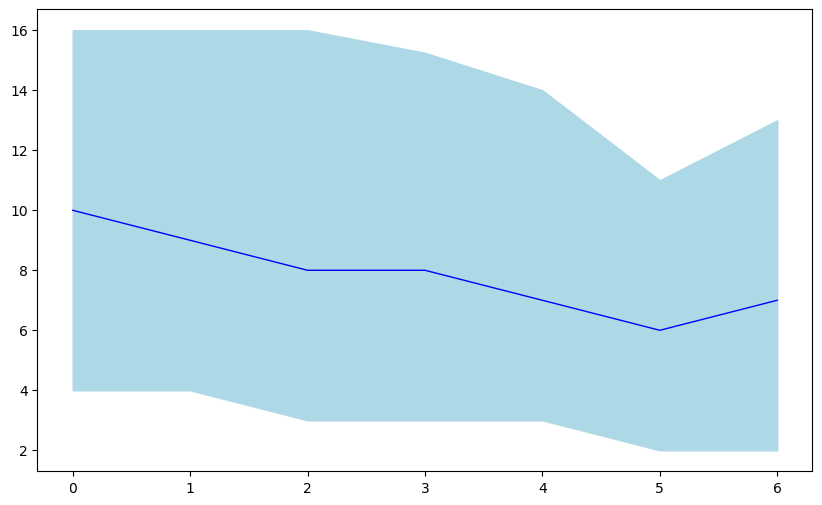

In [17]:
quantiles = [0.25, 0.50, 0.75]  # 25th and 75th percentiles

# Group by 15-minute intervals and calculate quantiles
df = rides_tf.groupby("weekday")['sum'].quantile(quantiles).reset_index()
df["level_1"] = df["level_1"].astype(str)
wide_df = df.pivot(index="weekday", columns='level_1', values='sum').reset_index()
wide_df
# date_null = datetime.date(2024,1,1)
# wide_df["datetime_null"] = wide_df["time"].apply(lambda x: datetime.datetime.combine(date_null, x))

# wide_df["ma025"] = wide_df["0.25"].rolling(6).mean()
# wide_df["ma075"] = wide_df["0.75"].rolling(6).mean()
# wide_df["ma050"] = (wide_df["ma025"] + wide_df["ma075"]) /2

plt.figure(figsize=(10, 6)) 

plt.plot(wide_df.index, wide_df["0.5"], color="blue", linewidth=1)

plt.fill_between(wide_df.index, wide_df["0.25"], wide_df["0.75"], color="lightblue")


In [ ]:
quantiles = [0.25, 0.50, 0.75]  # 25th and 75th percentiles

# Group by 15-minute intervals and calculate quantiles
df = rides_tf.groupby("day")['sum'].quantile(quantiles).reset_index()
df["level_1"] = df["level_1"].astype(str)
wide_df = df.pivot(index="day", columns='level_1', values='sum').reset_index()
wide_df
# date_null = datetime.date(2024,1,1)
# wide_df["datetime_null"] = wide_df["time"].apply(lambda x: datetime.datetime.combine(date_null, x))

# wide_df["ma025"] = wide_df["0.25"].rolling(6).mean()
# wide_df["ma075"] = wide_df["0.75"].rolling(6).mean()
# wide_df["ma050"] = (wide_df["ma025"] + wide_df["ma075"]) /2

plt.figure(figsize=(10, 6)) 

plt.plot(wide_df.index, wide_df["0.5"], color="blue", linewidth=1)

plt.fill_between(wide_df.index, wide_df["0.25"], wide_df["0.75"], color="lightblue")


In [ ]:
plt.figure(figsize=(14, 6)) 


for month in range(2,6):
    df = rides_tf[rides_tf["month"]==month]
    df = df.groupby("day")["sum"].sum().reset_index()
    plt.plot(df["day"], df["sum"], linewidth=1)

In [ ]:
rides_df_daily.plot()

# Queue

In [7]:
queue_df = get_sql_table("queue")

queue_df["datetime"] = pd.to_datetime(queue_df['date'].astype(str) + ' ' + queue_df['time'].astype(str), format='%Y-%m-%d %H:%M:%S')
queue_df = queue_df.groupby(pd.Grouper(key="datetime", freq="10min"))[["FT", "TH", "ME", "MU"]].mean().reset_index()
queue_df["sum"] = queue_df["FT"] + queue_df["TH"] + queue_df["ME"] + queue_df["MU"]
queue_df["sum_ma"] = queue_df["sum"].rolling(6).mean()
queue_df["sum_ma_me"] = queue_df["ME"].rolling(6).mean()

queue_df

datetime         FT         TH         ME         MU  \
0     2024-02-19 14:00:00  17.666667  17.595238   7.285714  19.214286   
1     2024-02-19 14:10:00  20.796610  19.288136   8.898305  20.186441   
2     2024-02-19 14:20:00  25.118644  25.271186  10.220339  21.627119   
3     2024-02-19 14:30:00  25.233333  31.533333  11.000000  21.416667   
4     2024-02-19 14:40:00  27.627119  34.813559  11.000000  21.000000   
...                   ...        ...        ...        ...        ...   
16842 2024-06-15 13:00:00   8.491228   9.666667   0.508772   9.245614   
16843 2024-06-15 13:10:00   8.403509  10.140351   0.105263  10.000000   
16844 2024-06-15 13:20:00   8.403509   8.859649   0.491228  10.000000   
16845 2024-06-15 13:30:00   8.625000  11.875000   0.214286   9.410714   
16846 2024-06-15 13:40:00  11.000000  10.625000   0.000000   8.000000   

             sum     sum_ma  sum_ma_me  
0      61.761905        NaN        NaN  
1      69.169492        NaN        NaN  
2      82.237288        NaN        NaN  
3      89.183333        NaN        NaN  
4      94.440678        NaN        NaN  
...          ...        ...        ...  
16842  27.912281  21.332237   0.117220  
16843  28.649123  23.633406   0.134764  
16844  27.754386  25.150950   0.216635  
16845  30.125000  26.499269   0.243578  
16846  29.625000  27.999269   0.228697  

[16847 rows x 8 columns]

In [8]:
px.line(queue_df, x="datetime", y=["FT", "TH", "ME", "MU"])

In [9]:
queue_df["time"] = queue_df["datetime"].dt.time
df = queue_df.groupby("time")["sum_ma"].mean().reset_index()
px.line(df, x="time", y="sum_ma", width=700, height=400)

In [10]:
rides_df["time"] = rides_df["datetime"].dt.time
df = rides_df.groupby("time")["sum_ma"].mean().reset_index()
px.line(df, x="time", y="sum_ma", width=700, height=400)

# Matkustajamäärät

In [ ]:
pax_df = get_sql_table("pax")

pax_df['date'] = np.where(pax_df['time'] == 24, pax_df['date'] + pd.Timedelta(hours=24), pax_df['date'])
pax_df['time'] = np.where(pax_df['time'] == 24, 0, pax_df['time'])

pax_df["datetime"] = pd.to_datetime(pax_df['date'].astype(str) + ' ' + pax_df['time'].astype(str).apply(lambda x: x.zfill(2)), format='%Y-%m-%d %H')

# not accurate only for EDA
pax_df["datetime"] = pax_df["datetime"] + pd.Timedelta(hours=2)

pax_df

# Flights

In [11]:
flights_df = get_sql_table("flights")

flights_df["datetime"] = pd.to_datetime(flights_df['date'].astype(str) + ' ' + flights_df['time'].astype(str), format='%Y-%m-%d %H:%M:%S')
flights_df = flights_df.groupby(pd.Grouper(key="datetime", freq="30min"))["Capacity"].sum().reset_index()
# flights_df["datetime"] = flights_df["datetime"] + pd.Timedelta(hours=1)
flights_df["date"] = flights_df["datetime"].dt.date
flights_df

datetime  Capacity        date
0    2024-02-19 04:00:00     350.0  2024-02-19
1    2024-02-19 04:30:00     350.0  2024-02-19
2    2024-02-19 05:00:00       0.0  2024-02-19
3    2024-02-19 05:30:00     700.0  2024-02-19
4    2024-02-19 06:00:00     674.0  2024-02-19
...                  ...       ...         ...
5651 2024-06-15 21:30:00     196.0  2024-06-15
5652 2024-06-15 22:00:00    1038.0  2024-06-15
5653 2024-06-15 22:30:00    1308.0  2024-06-15
5654 2024-06-15 23:00:00    1750.0  2024-06-15
5655 2024-06-15 23:30:00     678.0  2024-06-15

[5656 rows x 3 columns]

In [7]:
# flights_df["date_str"] = flights_df["date"].astype(str)
# flights_df = flights_df[~flights_df["date_str"].isin(dates_to_delete)]
# flights_df = flights_df.drop("date_str", axis=1)

# flights_df.reset_index(inplace=True, drop=True)
# flights_df["i"] = flights_df.index
# px.line(flights_df, x="i", y="Capacity")

## EDA

In [19]:
roll_win = 4

flights_df_s = flights_df[flights_df["datetime"]>dt.datetime(2024,5,4)]
rides_df_s = rides_df[rides_df["datetime"]>dt.datetime(2024,5,4)]
rides_df_s = rides_df_s.groupby(pd.Grouper(key="datetime", freq="30min"))["sum"].sum().reset_index()

rides_df_s["ma_rides"] = rides_df_s["sum"].rolling(roll_win).mean()
flights_df_s["ma_flights"] = flights_df_s["Capacity"].rolling(roll_win).mean()

rides_df_s["ma_rides"] = rides_df_s["ma_rides"].shift(-1)
# flights_df_s["ma"] = flights_df_s["ma"].shift(1)


In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=flights_df_s["datetime"], y=flights_df_s["ma_flights"], line_shape="spline", name="flights", marker=dict(color="blue")), secondary_y=False)
fig.add_trace(go.Scatter(x=rides_df_s["datetime"], y=rides_df_s["ma_rides"], name="rides", marker=dict(color="red")), secondary_y=True)
# fig.add_trace(go.Scatter(x=rides_df_s["datetime"], y=rides_df_s["sum"], name="rides", marker=dict(color="darkkhaki")), secondary_y=True)


fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left'},
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right'},
                #   plot_bgcolor='white'
                  ))

In [ ]:
diff_df = rides_df_s.merge(flights_df_s, on="datetime")
diff_df = diff_df[["datetime", "ma_rides","ma_flights"]]
diff_df

In [11]:
diff_df["x"] = diff_df["ma_rides"] / diff_df["ma_flights"]
diff_df

datetime  ma_rides  ma_flights         x
0    2024-05-04 00:30:00       NaN         NaN       NaN
1    2024-05-04 01:00:00     25.75         NaN       NaN
2    2024-05-04 01:30:00     23.25         NaN       NaN
3    2024-05-04 02:00:00     17.00       121.5  0.139918
4    2024-05-04 02:30:00     14.00       111.0  0.126126
...                  ...       ...         ...       ...
998  2024-05-24 19:30:00     45.25       554.0  0.081679
999  2024-05-24 20:00:00     47.00       548.5  0.085688
1000 2024-05-24 20:30:00     40.00       457.0  0.087527
1001 2024-05-24 21:00:00     32.00       452.0  0.070796
1002 2024-05-24 21:30:00       NaN       345.0       NaN

[1003 rows x 4 columns]

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=flights_df_s["datetime"], y=flights_df_s["ma_flights"], line_shape="spline", name="flights", marker=dict(color="blue")), secondary_y=False)
fig.add_trace(go.Scatter(x=rides_df_s["datetime"], y=rides_df_s["ma_rides"], name="rides", marker=dict(color="red")), secondary_y=True)
fig.add_trace(go.Scatter(x=diff_df["datetime"], y=diff_df["x"]*1000, name="x", marker=dict(color="darkkhaki")), secondary_y=True)


fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left'},
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right'}))

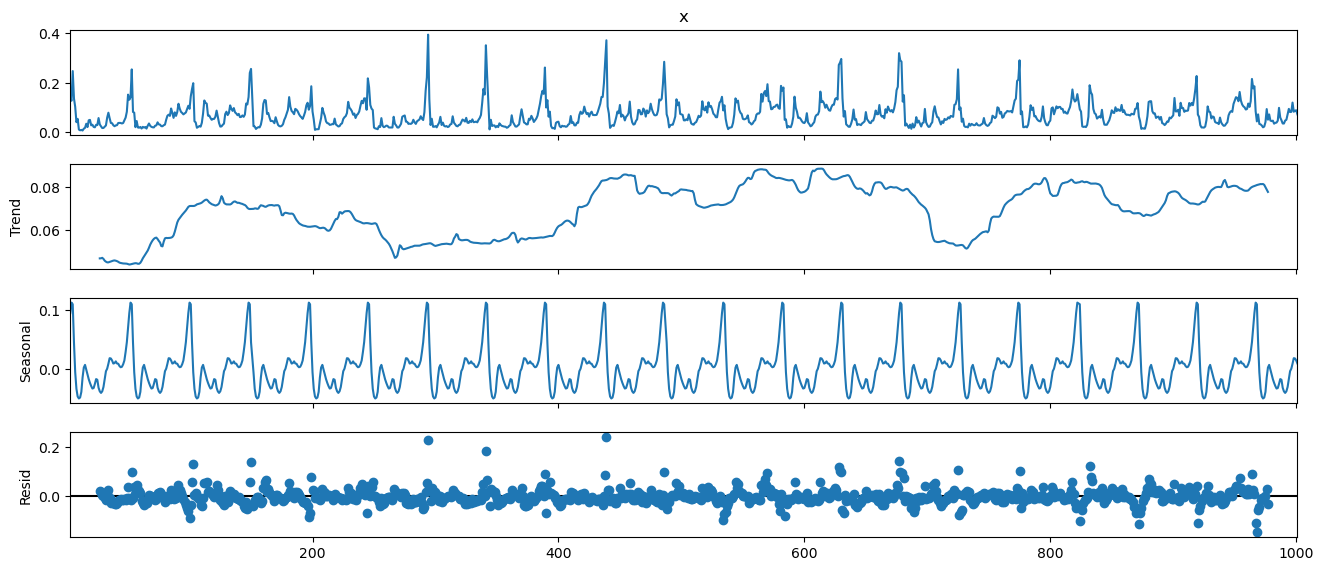

In [33]:
series = diff_df["x"].replace(np.inf,np.nan).dropna()

result = seasonal_decompose(series, model='additive', period=48)
fig = result.plot()
fig.set_size_inches((15, 6))
plt.show()

In [41]:
def normalize_df(series):
    return (series - series.min()) / (series.max() - series.min())

In [44]:
seasonal_series = result.seasonal
seasonal_series = normalize_df(seasonal_series)

In [45]:
diff_df["forecast"] = diff_df["ma_flights"] * seasonal_series
diff_df

datetime  ma_rides  ma_flights         x    forecast
0    2024-05-04 00:30:00       NaN         NaN       NaN         NaN
1    2024-05-04 01:00:00     25.75         NaN       NaN         NaN
2    2024-05-04 01:30:00     23.25         NaN       NaN         NaN
3    2024-05-04 02:00:00     17.00       121.5  0.139918  108.209665
4    2024-05-04 02:30:00     14.00       111.0  0.126126  111.000000
...                  ...       ...         ...       ...         ...
998  2024-05-24 19:30:00     45.25       554.0  0.081679  232.880004
999  2024-05-24 20:00:00     47.00       548.5  0.085688  229.086162
1000 2024-05-24 20:30:00     40.00       457.0  0.087527  181.025006
1001 2024-05-24 21:00:00     32.00       452.0  0.070796  164.774005
1002 2024-05-24 21:30:00       NaN       345.0       NaN         NaN

[1003 rows x 5 columns]

In [51]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Scatter(x=flights_df_s["datetime"], y=flights_df_s["ma_flights"], line_shape="spline", name="flights", marker=dict(color="blue")), secondary_y=False)
fig.add_trace(go.Scatter(x=rides_df_s["datetime"], y=rides_df_s["ma_rides"], name="rides", marker=dict(color="red")), secondary_y=True)
fig.add_trace(go.Scatter(x=diff_df["datetime"], y=diff_df["forecast"]*0.2, name="ennuste", marker=dict(color="darkkhaki")), secondary_y=True)


fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left'},
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right'}))

# ALL

In [12]:
np.random.seed(0)
dates = pd.date_range(start='2024-02-19', end='2024-05-20', freq='7D')
values = np.random.rand(len(dates))
df = pd.DataFrame({'Date': dates, 'Value': values})
df

Date     Value
0  2024-02-19  0.548814
1  2024-02-26  0.715189
2  2024-03-04  0.602763
3  2024-03-11  0.544883
4  2024-03-18  0.423655
5  2024-03-25  0.645894
6  2024-04-01  0.437587
7  2024-04-08  0.891773
8  2024-04-15  0.963663
9  2024-04-22  0.383442
10 2024-04-29  0.791725
11 2024-05-06  0.528895
12 2024-05-13  0.568045
13 2024-05-20  0.925597

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Bar(x=pax_df["datetime"], y=pax_df["pax"], marker_color='lightblue', width=7200000, marker_line=dict(width=0), name="pax (+1h)"), secondary_y=False)
fig.add_trace(go.Scatter(x=flights_df["datetime"], y=flights_df["ma"], line_shape="spline", name="pax_e", marker=dict(color="blue")), secondary_y=False)
fig.add_trace(go.Scatter(x=rides_df["datetime"], y=rides_df["sum_ma"], name="rides", marker=dict(color="red")), secondary_y=True)
# fig.add_trace(go.Scatter(x=queue_df["datetime"], y=queue_df["sum_ma"], name="queue (sum)", marker=dict(color="green")), secondary_y=False)

for date in dates:
    fig.add_vline(x=date, line_width=4)

fig.update_layout(bargap=0)

fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left'},
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right'},
                #   plot_bgcolor='white'
                  ))

In [ ]:
pax_df_d = pax_df.groupby("date")["pax"].sum().reset_index().replace(0,np.nan)
pax_df_d = pax_df_d[pax_df_d["pax"]>1400]
flights_df["date"] = flights_df["datetime"].dt.date
flights_df_d = flights_df.groupby("date")["Capacity"].sum().reset_index().replace(0,np.nan)
flights_df_d = flights_df_d[flights_df_d["Capacity"]>21000]
rides_df["date"] = rides_df["datetime"].dt.date
rides_df_d = rides_df.groupby("date")["sum"].sum().reset_index().replace(0,np.nan)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=pax_df_d["date"], y=pax_df_d["pax"], marker=dict(color="lightblue"), name="pax (+1h)", line_shape="spline"), secondary_y=False)
fig.add_trace(go.Scatter(x=flights_df_d["date"], y=flights_df_d["Capacity"], line_shape="spline", name="pax_e (+1h)", marker=dict(color="blue")), secondary_y=False)
fig.add_trace(go.Scatter(x=rides_df_d["date"], y=rides_df_d["sum"], name="rides", marker=dict(color="red"), line_shape="spline"), secondary_y=True)
# fig.add_trace(go.Scatter(x=queue_df["datetime"], y=queue_df["sum_ma"], name="queue (sum)", marker=dict(color="green")), secondary_y=False)

fig.update_layout(bargap=0)

fig.update_layout(dict(yaxis2={'anchor': 'x', 'overlaying': 'y', 'side': 'left'},
                  yaxis={'anchor': 'x', 'domain': [0.0, 1.0], 'side':'right'}))